# Investigating ML Throughput

In [4]:
# Loading event json
import json
import math
# Plotting the timeline
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

CPU-Centric:

Memory-Centric:

Mixed-Centric:

Spazio:  
start = 1748381897  
end = 1748382006

Kube 100:  
start = 1748383167  
end = 1748383311

Kube:  
start = 1748380187  
end = 1748380292

In [67]:
experiments = {
    'spazio-100-ml' : {
        'start' : 1748387478,
        'end' : 1748387664,
        'Name' : 'CARICO',
        'drop' : '10.244.29.56:32000'
    },
    'spazio-200-ml' : {
        'start' : 1748390035,
        'end' : 1748390377,
        'Name' : 'CARICO',
        'drop': '10.244.29.56:32000',
    },
    'kube-100-ml' : {
        'start' : 1748383167, 
        'end' : 1748383311,
        'Name' : 'Default Scheduler with 200m CPU and 750Mi Mem Request',
        'drop' : '10.244.29.56:32000'
    },
    'kube-200-ml' : {
        'start' : 1748384687,
        'end' : 1748385019,
        'Name' : 'Default Scheduler with 200m CPU and 750Mi Mem Request',
        'drop': '10.244.29.56:32000'
    }
}
keys = ['kube-100-ml', 'kube-200-ml','spazio-100-ml','spazio-200-ml']

In [73]:
exp = 'spazio-200-ml'

## Pod Completion

In [74]:
try:
    df = pd.read_csv(f'{exp}-pod-completion.csv')
    df = df.drop(columns=['Time'])
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

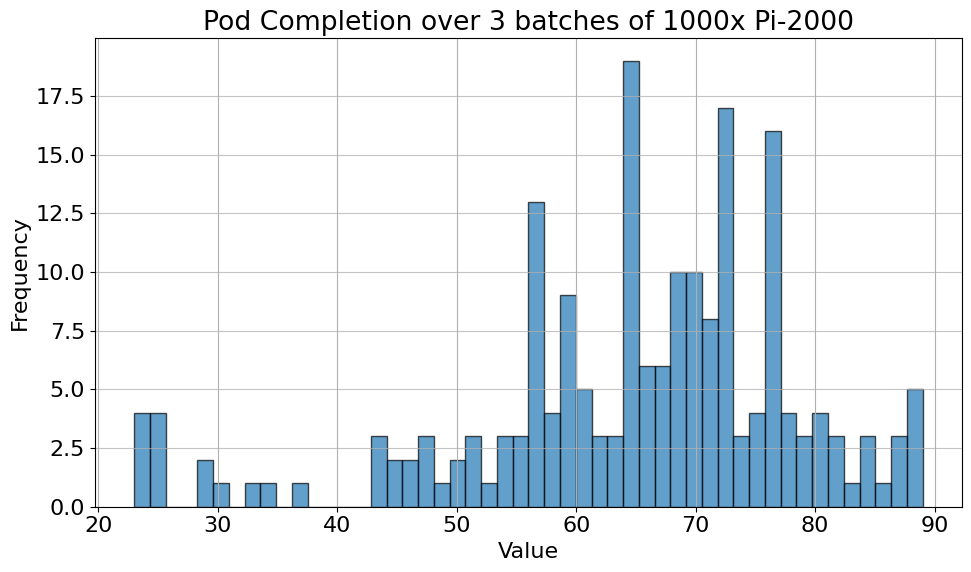

In [75]:
single_row = df.iloc[0] # This will be a pandas Series

# Alternatively, convert the DataFrame to a NumPy array and flatten it
# single_row_array = df.to_numpy().flatten()

# 3. Create the histogram

# Method A: Using pandas built-in .hist() method (most straightforward)
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability
single_row.hist(bins=50, edgecolor='black', alpha=0.7) # bins determines the number of bars
plt.title('Pod Completion over 3 batches of 1000x Pi-2000')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
# plt.savefig('figures/pi-2000-1000x-pod-completion.png')
plt.show()


In [76]:
statistical_summary = single_row.describe()

print("\n--- Statistical Summary (using .describe()) ---")
print(statistical_summary)

# 4. Customizing Percentiles (if you need specific ones)
# You can specify the percentiles you want using the 'percentiles' argument in describe()
custom_percentiles = single_row.describe(percentiles=[.01, .10, .25, .50, .75, .90, .99])

print("\n--- Statistical Summary with Custom Percentiles ---")
print(custom_percentiles)

# 5. Extracting individual percentiles if needed
# You can also get individual percentiles using the .quantile() method
p10 = single_row.quantile(0.10)
p90 = single_row.quantile(0.90)

print(f"\nValue at 10th percentile: {p10:.2f}")
print(f"Value at 90th percentile: {p90:.2f}")


--- Statistical Summary (using .describe()) ---
count    200.0000
mean      64.4550
std       14.3281
min       23.0000
25%       57.7500
50%       67.0000
75%       73.2500
max       89.0000
Name: 0, dtype: float64

--- Statistical Summary with Custom Percentiles ---
count    200.0000
mean      64.4550
std       14.3281
min       23.0000
1%        23.9900
10%       46.0000
25%       57.7500
50%       67.0000
75%       73.2500
90%       79.1000
99%       88.0100
max       89.0000
Name: 0, dtype: float64

Value at 10th percentile: 46.00
Value at 90th percentile: 79.10


## Pod Running

In [59]:
def read_running(name):
    try:
        df = pd.read_csv(f'{name}-pod-running.csv')
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')
        df = df.set_index('Time')
        # df = df - 1
        # df.index = pd.to_datetime(df.index, errors='coerce')
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

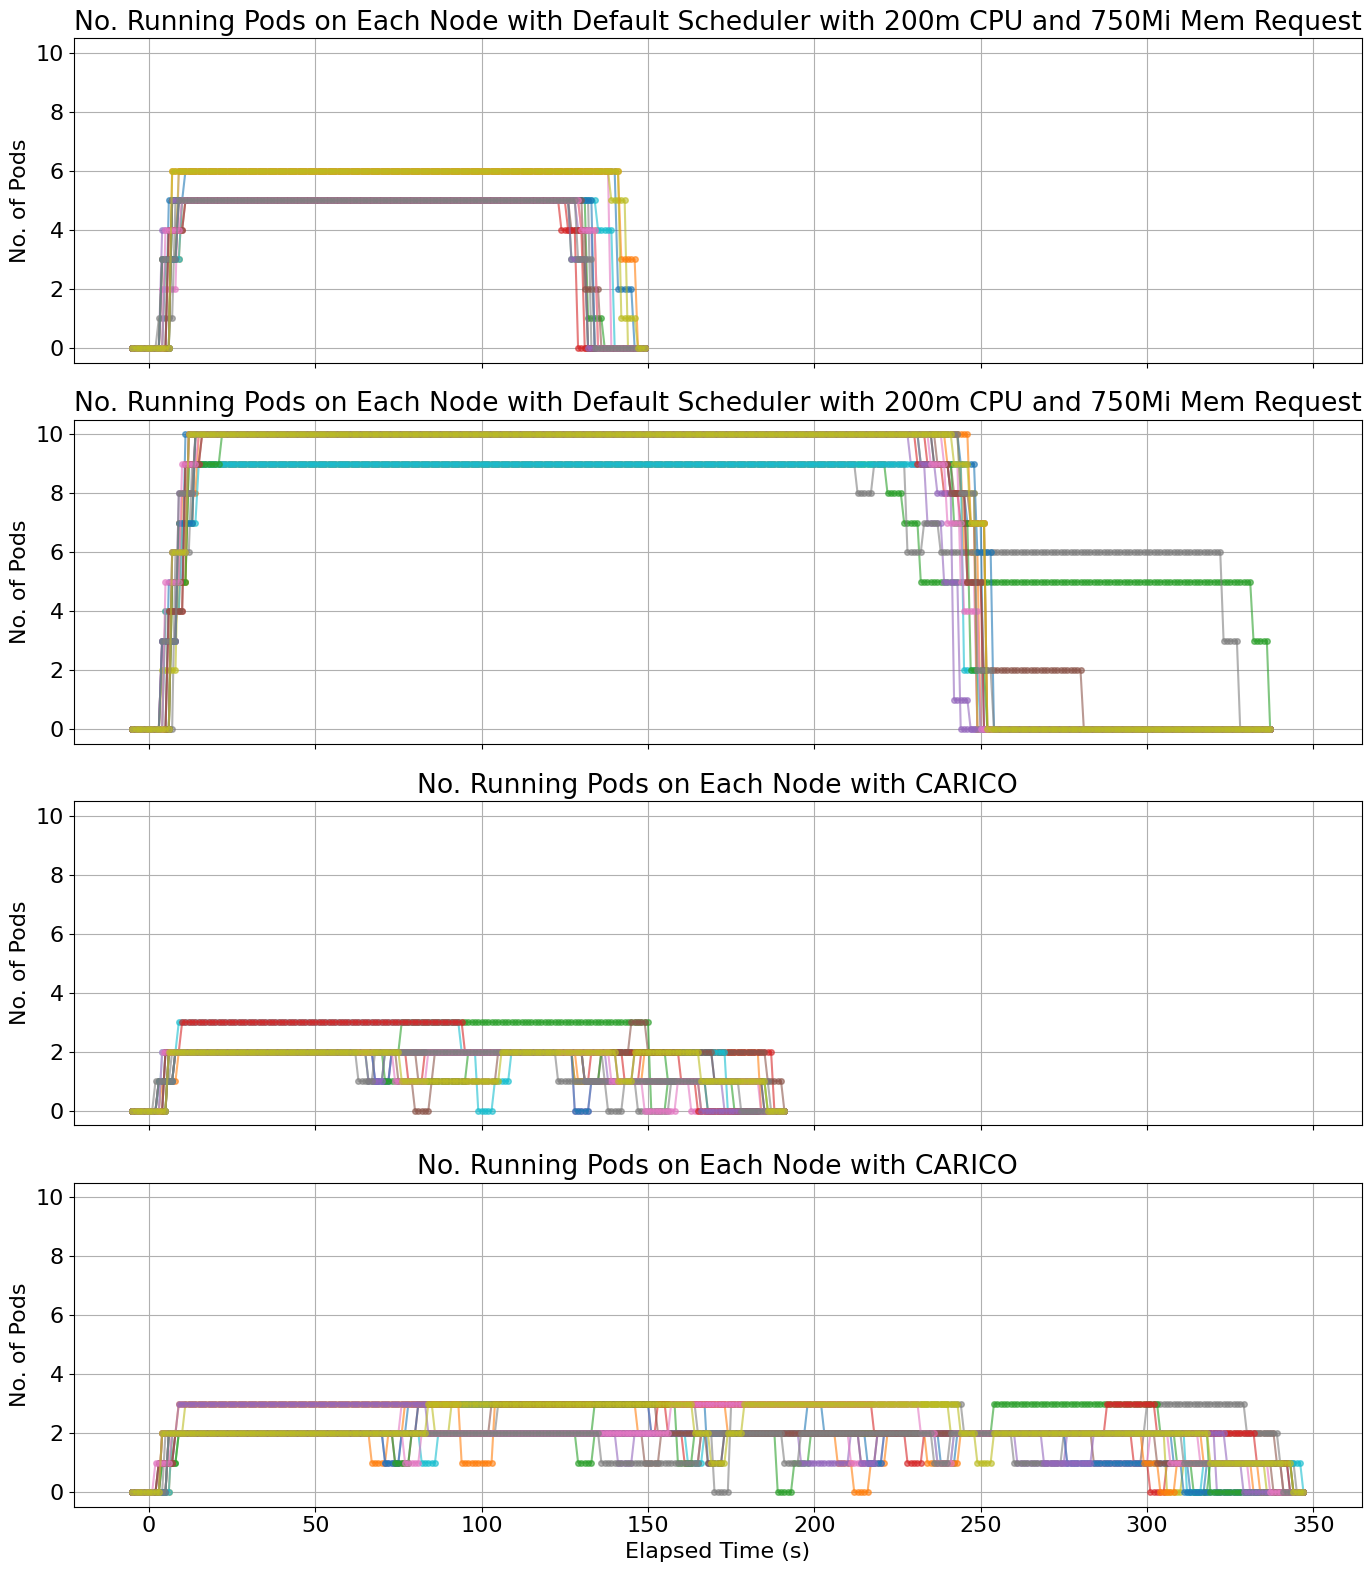

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(len(keys), 1, figsize=(14, 4 * len(keys)), sharex=True, sharey=True)
plt.rcParams['font.size'] = 16

for i in range(len(keys)):
    key = keys[i]
    df = read_running(key)
    if 'spazio' in key:
        df = df - 1
# 2. Slice the DataFrame to the restricted time range
# df.loc[start_dt:end_dt] directly works because df.index is now DatetimeIndex

    df_restricted = df.loc[pd.to_datetime(experiments[key]['start'] -5, unit='s'): pd.to_datetime(experiments[key]['end']+5, unit='s')]
    
    time_elapsed_seconds = (df_restricted.index - pd.to_datetime(experiments[key]['start'], unit='s')).total_seconds()
    df_restricted.index = time_elapsed_seconds
    if df_restricted.empty:
        print(f"\nNo data found for the specified time range: {start_dt} to {end_dt}. Please check your CSV data's time range.")
    else:
        # 3. Plot the number of pods on each node as a line graph
     
        df_restricted.plot(kind='line', marker='o', linestyle='-', ax=axes[i], markersize=4, alpha=0.6, legend=False) # Plot df_restricted directly
    
        axes[i].set_title(f'No. Running Pods on Each Node with {experiments[key]['Name']}')
        axes[i].set_xlabel('Elapsed Time (s)')
        axes[i].set_ylabel('No. of Pods')
        axes[i].grid(True)
        # plt.legend(title='Node', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside to avoid obscuring lines
    
        # # --- Original second graph (Stacked Area Plot of Total Pods by Node) ---
        # plt.figure(figsize=(12, 6))
        # df_restricted.plot(kind='area', stacked=True, ax=plt.gca(), cmap='viridis', legend=False)
        # plt.title('Running Pods Over Time (Stacked by Node)')
        # plt.xlabel('Elapsed Time (s)')
        # plt.ylabel('Total Pods')
        # plt.grid(True)
        # plt.xticks(rotation=45)
        # # plt.legend(title='Node', bbox_to_anchor=(1.05, 1), loc='upper left')
        # plt.tight_layout()
        # plt.show()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../figures/ml-running-pods.png')    
plt.show()

## Resource Utilisation

In [61]:
def read_df(filepath):
    try:
        df = pd.read_csv(filepath)
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')
        df = df.set_index('Time')
    
        # df.index = pd.to_datetime(df.index, errors='coerce')
        # df.info()

        return df
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

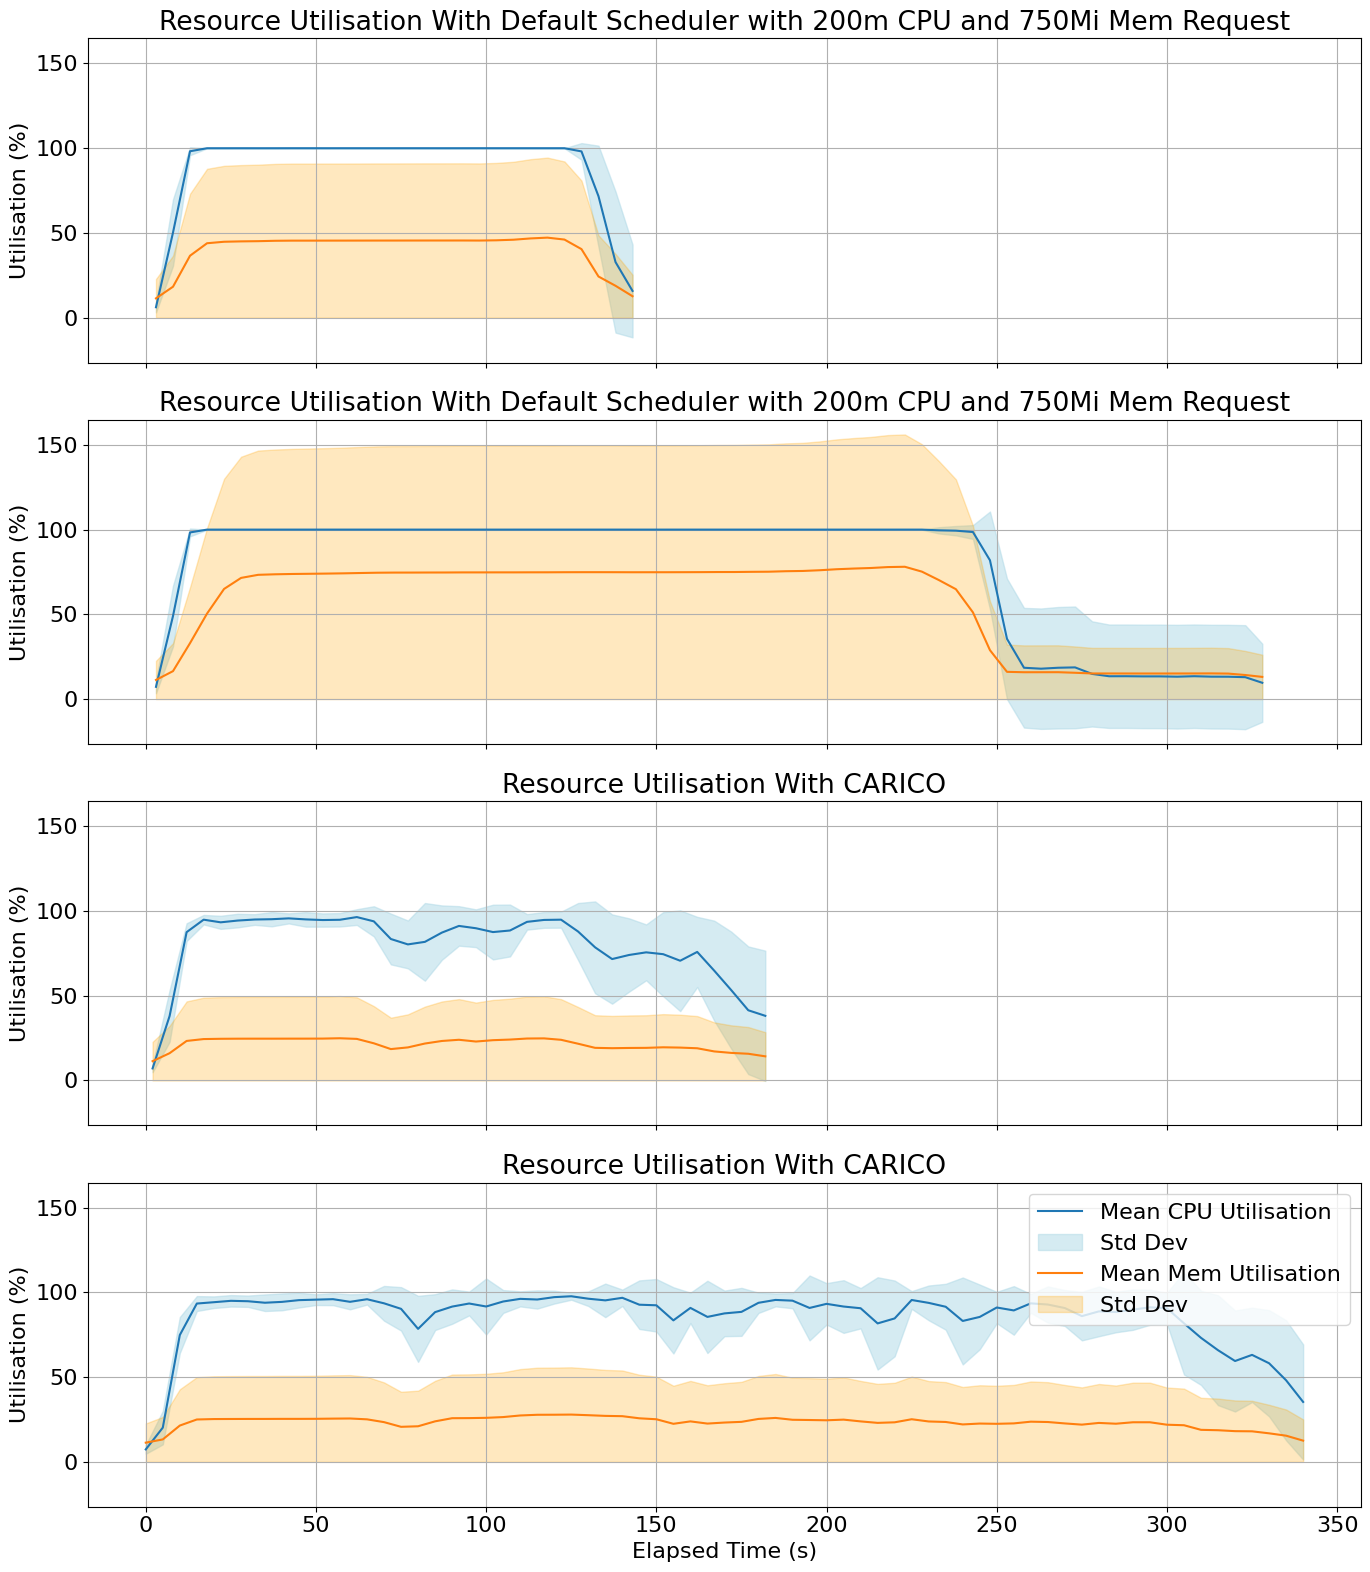

In [68]:
fig, axes = plt.subplots(len(keys), 1, figsize=(14, 4 * len(keys)), sharex=True, sharey=True)
plt.rcParams['font.size'] = 16

for i in range(len(keys)):
    key = keys[i]
    df = read_running(key)
# 2. Slice the DataFrame to the restricted time range
# df.loc[start_dt:end_dt] directly works because df.index is now DatetimeIndex

    cpu = read_df(f'{key}-cpu-util.csv')
    mem = read_df(f'{key}-mem-util.csv')
    mem = mem.drop(columns=[experiments[key]['drop']])
    
    # Calculate the mean CPU utilization across all machines for each time point
    cpu_mean = cpu.loc[pd.to_datetime(experiments[key]['start'], unit='s'): pd.to_datetime(experiments[key]['end'], unit='s')].mean(axis=1)
    cpu_time = (cpu_mean.index - pd.to_datetime(experiments[key]['start'], unit='s')).total_seconds()
    cpu_mean.index = cpu_time
    
    # Calculate the standard deviation of CPU utilization across all machines for each time point
    cpu_std = cpu.loc[pd.to_datetime(experiments[key]['start'], unit='s'): pd.to_datetime(experiments[key]['end'], unit='s')].std(axis=1)
    cpu_std.index = cpu_time
    
    mem_mean = mem.loc[pd.to_datetime(experiments[key]['start'], unit='s'): pd.to_datetime(experiments[key]['end'], unit='s')].mean(axis=1)
    mem_time = (mem_mean.index - pd.to_datetime(experiments[key]['start'], unit='s')).total_seconds()
    mem_mean.index = mem_time
    
    # Calculate the standard deviation of mem utilization across all machines for each time point
    mem_std = mem.loc[pd.to_datetime(experiments[key]['start'], unit='s'): pd.to_datetime(experiments[key]['end'], unit='s')].mean(axis=1)
    mem_std.index = mem_time
    
    # Plot the mean and standard deviation over time
    axes[i].plot(cpu_mean.index, cpu_mean, label='Mean CPU Utilisation')
    axes[i].fill_between(cpu_mean.index, cpu_mean - cpu_std,
                     cpu_mean + cpu_std, color='lightblue', alpha=0.5, label='Std Dev')
    axes[i].plot(mem_mean.index, mem_mean, label='Mean Mem Utilisation')
    axes[i].fill_between(mem_mean.index, mem_mean - mem_std,
                     mem_mean + mem_std, color='orange', alpha=0.25, label='Std Dev')
    # axes[i].tick_params(axis='x', labelbottom=False)
    axes[i].set_title(f'Resource Utilisation With {experiments[key]['Name']}')
    axes[i].set_ylabel('Utilisation (%)')
    axes[i].grid(True)

axes[len(keys)-1].set_xlabel('Elapsed Time (s)')
axes[len(keys)-1].legend()
plt.tight_layout()
plt.savefig(f'../figures/ml-util.png')
plt.show()

In [66]:
read_df(f'{key}-mem-util.csv')

Time
2025-05-27 23:53:40    31.385702
2025-05-27 23:53:45    31.366893
2025-05-27 23:53:50    31.370093
2025-05-27 23:53:55    31.381443
2025-05-27 23:54:00    31.479105
                         ...    
2025-05-27 23:59:25    37.861422
2025-05-27 23:59:30    37.900123
2025-05-27 23:59:35    37.908592
2025-05-27 23:59:40    31.605917
2025-05-27 23:59:45    31.593066
Name: 10.244.29.56:32000, Length: 74, dtype: float64